In [2]:
!unzip data.zip
%ls

Archive:  data.zip
   creating: data/
   creating: data/normal/
  inflating: data/normal/1.jpg       
  inflating: data/normal/10.jpg      
  inflating: data/normal/100.jpg     
  inflating: data/normal/11.jpg      
  inflating: data/normal/12.jpg      
  inflating: data/normal/13.jpg      
  inflating: data/normal/14.jpg      
  inflating: data/normal/15.jpg      
  inflating: data/normal/16.jpg      
  inflating: data/normal/17.jpg      
  inflating: data/normal/18.jpg      
  inflating: data/normal/19.jpg      
  inflating: data/normal/2.jpg       
  inflating: data/normal/20.jpg      
  inflating: data/normal/21.jpg      
  inflating: data/normal/22.jpg      
  inflating: data/normal/23.jpg      
  inflating: data/normal/24.jpg      
  inflating: data/normal/25.jpg      
  inflating: data/normal/26.jpg      
  inflating: data/normal/27.jpg      
  inflating: data/normal/28.jpg      
  inflating: data/normal/29.jpg      
  inflating: data/normal/3.jpg       
  inflating: data/normal

In [44]:
!pip install onnx
!pip install onnxruntime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.0 MB/s eta 0:00:00


In [46]:
import os
import torch
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import onnx
import onnxruntime as ort


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from PIL import Image

class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_dir, transform=None):
        self.dataset_dir = dataset_dir
        self.transform = transform
        self.images, self.labels = [], []
        for dirpath, _, filenames in os.walk(dataset_dir):
            for filename in filenames:
                label = 0 if 'normal' in dirpath else 1
                img_path = os.path.join(dirpath, filename)
                self.images.append(img_path)
                self.labels.append(label)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

In [29]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [30]:
from tqdm import tqdm

k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

def train_and_evaluate(model_name, model, dataset, train_transform, val_transform):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    model_dir = f"models/{model_name}"
    os.makedirs(model_dir, exist_ok=True)

    all_train_losses, all_test_losses = [], []
    all_train_accs, all_test_accs = [], []
    all_fprs, all_tprs, roc_aucs = [], [], []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f'Fold {fold+1}/{k_folds} for {model_name}')
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)

        train_subset.dataset.transform = train_transform
        test_subset.dataset.transform = val_transform

        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

        best_acc = 0.0
        for epoch in tqdm(range(10), desc=f"Training {model_name} Fold {fold+1}"):
            model.train()
            running_loss, correct = 0.0, 0

            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                correct += (outputs.argmax(1) == labels).sum().item()

            epoch_acc = correct / len(train_subset)
            all_train_losses.append(running_loss / len(train_subset))
            all_train_accs.append(epoch_acc)

            model.eval()
            correct, total, test_loss = 0, 0, 0.0
            all_preds, all_targets = [], []
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * inputs.size(0)
                    correct += (outputs.argmax(1) == labels).sum().item()
                    total += labels.size(0)
                    all_preds.extend(outputs.softmax(1)[:, 1].cpu().numpy())
                    all_targets.extend(labels.cpu().numpy())

            epoch_test_acc = correct / total
            all_test_losses.append(test_loss / total)
            all_test_accs.append(epoch_test_acc)

            fpr, tpr, _ = roc_curve(all_targets, all_preds)
            all_fprs.append(fpr)
            all_tprs.append(tpr)
            roc_aucs.append(auc(fpr, tpr))

            if epoch_test_acc > best_acc:
                best_acc = epoch_test_acc
                torch.save(model.state_dict(), f"{model_dir}/best_model_fold_{fold}.pth")

    torch.save(model.state_dict(), f"{model_dir}/final_model.pth")

    return all_train_losses, all_test_losses, all_train_accs, all_test_accs, all_fprs, all_tprs, roc_aucs

In [33]:
models_dict = {
    'MobileNetV2': models.mobilenet_v2(weights='IMAGENET1K_V2'),
    'MobileNetV3': models.mobilenet_v3_large(weights='IMAGENET1K_V2'),
    'ShuffleNetV2': models.shufflenet_v2_x1_0(weights='IMAGENET1K_V1'),
    'VisionTransformer': models.vit_b_16(weights='IMAGENET1K_V1')
}

In [34]:
results = {}
for model_name, model in tqdm(models_dict.items(), desc="Training Models"):
    print(f"Training {model_name}")
    results[model_name] = train_and_evaluate(model_name, model, dataset, train_transform, val_transform)


Training Models:   0%|          | 0/4 [00:00<?, ?it/s]

Training MobileNetV2
Fold 1/5 for MobileNetV2



Training MobileNetV2 Fold 1: 100%|██████████| 10/10 [08:17<00:00, 49.78s/it]


Fold 2/5 for MobileNetV2



Training MobileNetV2 Fold 2: 100%|██████████| 10/10 [08:25<00:00, 50.59s/it]


Fold 3/5 for MobileNetV2



Training MobileNetV2 Fold 3: 100%|██████████| 10/10 [08:30<00:00, 51.03s/it]


Fold 4/5 for MobileNetV2



Training MobileNetV2 Fold 4: 100%|██████████| 10/10 [08:19<00:00, 49.97s/it]


Fold 5/5 for MobileNetV2



Training Models:  25%|██▌       | 1/4 [41:59<2:05:57, 2519.17s/it]

Training MobileNetV3
Fold 1/5 for MobileNetV3



Training MobileNetV3 Fold 1: 100%|██████████| 10/10 [06:28<00:00, 38.82s/it]


Fold 2/5 for MobileNetV3



Training MobileNetV3 Fold 2: 100%|██████████| 10/10 [06:30<00:00, 39.06s/it]


Fold 3/5 for MobileNetV3



Training MobileNetV3 Fold 3: 100%|██████████| 10/10 [06:29<00:00, 38.98s/it]


Fold 4/5 for MobileNetV3



Training MobileNetV3 Fold 4: 100%|██████████| 10/10 [06:29<00:00, 38.93s/it]


Fold 5/5 for MobileNetV3



Training Models:  50%|█████     | 2/4 [1:14:28<1:12:48, 2184.24s/it]

Training ShuffleNetV2
Fold 1/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 1: 100%|██████████| 10/10 [03:48<00:00, 22.83s/it]


Fold 2/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 2: 100%|██████████| 10/10 [03:46<00:00, 22.69s/it]


Fold 3/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 3: 100%|██████████| 10/10 [03:47<00:00, 22.80s/it]


Fold 4/5 for ShuffleNetV2



Training ShuffleNetV2 Fold 4: 100%|██████████| 10/10 [03:50<00:00, 23.04s/it]


Fold 5/5 for ShuffleNetV2



Training Models:  75%|███████▌  | 3/4 [1:33:31<28:28, 1708.36s/it]  

Training VisionTransformer
Fold 1/5 for VisionTransformer



Training VisionTransformer Fold 1: 100%|██████████| 10/10 [1:08:39<00:00, 411.95s/it]


Fold 2/5 for VisionTransformer



Training VisionTransformer Fold 2: 100%|██████████| 10/10 [1:08:41<00:00, 412.18s/it]


Fold 3/5 for VisionTransformer



Training VisionTransformer Fold 3: 100%|██████████| 10/10 [1:08:40<00:00, 412.05s/it]


Fold 4/5 for VisionTransformer



Training VisionTransformer Fold 4: 100%|██████████| 10/10 [1:08:36<00:00, 411.67s/it]


Fold 5/5 for VisionTransformer



Training Models: 100%|██████████| 4/4 [7:17:01<00:00, 6555.30s/it]


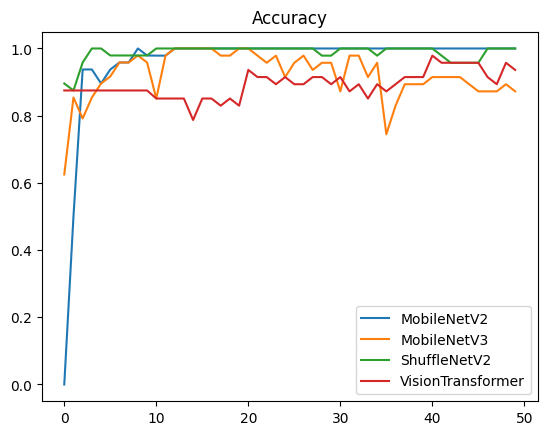

In [37]:
plt.figure()
for model_name, (train_losses, test_losses, train_accs, test_accs, fprs, tprs, roc_aucs) in results.items():
    plt.plot(test_accs, label=model_name)
plt.legend()
plt.title("Accuracy")
plt.show()


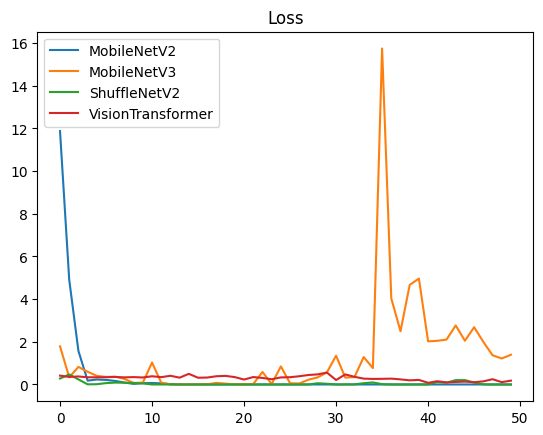

In [38]:
plt.figure()
for model_name, (train_losses, test_losses, train_accs, test_accs, fprs, tprs, roc_aucs) in results.items():
    plt.plot(test_losses, label=model_name)
plt.legend()
plt.title("Loss")
plt.show()

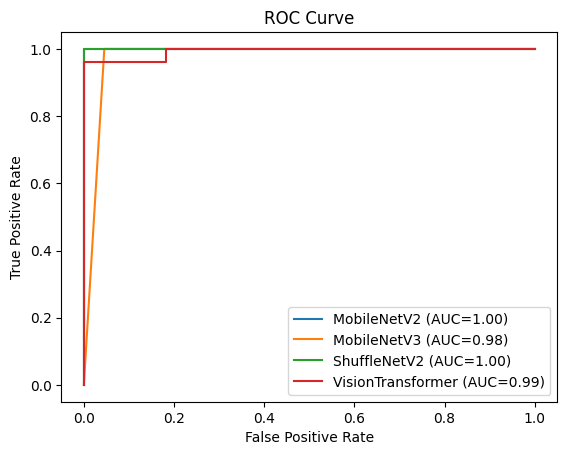

In [39]:
plt.figure()
for model_name, (train_losses, test_losses, train_accs, test_accs, fprs, tprs, roc_aucs) in results.items():
    plt.plot(fprs[-1], tprs[-1], label=f"{model_name} (AUC={roc_aucs[-1]:.2f})")
plt.legend()
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()


In [49]:
!pip install onnx-tf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 25.7 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.2
    Uninstalling typeguard-4.4.2:
      Successfully uninstalled typeguard-4.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.5.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.


In [53]:
!pip install keras

In [55]:
!pip install --upgrade tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 847.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 84.7 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0

In [ ]:
model_mapping = {
    "MobileNetV2": models.mobilenet_v2,
    "MobileNetV3": models.mobilenet_v3_large,
    "ShuffleNetV2": models.shufflenet_v2_x1_0,
    "VisionTransformer": models.vit_b_16
}

for model_name, model_fn in model_mapping.items():
    model_path = f"models/{model_name}/final_model.pth"
    if os.path.exists(model_path):
        model = model_fn(weights=None)
        model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'), weights_only=True))
        model.eval()

        dummy_input = torch.randn(1, 3, 224, 224)
        onnx_filename = f"models/{model_name}/model.onnx"
        tflite_filename = f"models/{model_name}/model.tflite"

        torch.onnx.export(model, dummy_input, onnx_filename, opset_version=16)

        onnx_model = onnx.load(onnx_filename)
        onnx.checker.check_model(onnx_model)

        # Конвертация ONNX в TFLite с использованием ONNX Runtime
        try:
            import onnx_tf
            from onnx_tf.backend import prepare
            tf_rep = prepare(onnx_model)
            tf_rep.export_graph(f"models/{model_name}/model_saved_model")

            converter = tf.lite.TFLiteConverter.from_saved_model(f"models/{model_name}/model_saved_model")
            tflite_model = converter.convert()
            with open(tflite_filename, "wb") as f:
                f.write(tflite_model)

            size_mb = os.path.getsize(tflite_filename) / (1024 * 1024)
            print(f"{model_name} TFLite size: {size_mb:.2f} MB")

        except Exception as e:
            print(f"Error converting {model_name} model to TFLite: {e}")
    else:
        print(f"Warning: {model_path} not found. Skipping conversion for {model_name}.")